## Tutorial notebook

This Jupyter notebook shows how to perform a basic analysis of γ-ray photon-count maps using the convolutional neural network-based method presented in [arXiv:2107.09070](http://arxiv.org/abs/2107.09070). 

In this example, the photon-count maps consist of **three** different emission components:    
1. *Fermi* bubbles (Poissonian)
2. Galactic Center Excess (point source-like, single population)
3. Isotropic point sources (point source-like, two populations in each map).

As discussed in the paper, for the point source-like templates the Poissonian case is included as the limit of ultra-faint point source emission (<< 1 photon expected per source) where the neural network can no longer distinguish point sources from Poissonian emission.

To consider different scenarios (e.g. other templates, more training data, different network architectures, etc.), simply modify the sample parameter file ```GCE_NN/parameter_files/parameters.py``` accordingly.


In [1]:
%pip install matplotlib==3.4.3
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os

Now, let's fetch the non-standard modules that we will need from pip.

In [2]:
%pip install healpy
%pip install ray[default]
%pip install git+https://github.com/jafluri/pygsp.git@ff32b490f7550b452fb27865d9cb9e8646602143  # PyGSP
import healpy as hp

Let's install the GCE NN module (this can be skipped if this has already been done outside this notebook). 

In [3]:
os.chdir("..")
!python setup.py install  # if the current working directory is GCE_NN/examples, 
                          # setup.py is in the parent directory
os.chdir("examples")

Cloning into 'GCE_NN'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 257 (delta 44), reused 174 (delta 36), pack-reused 69
Receiving objects: 100% (257/257), 141.86 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (50/50), done.
...
Installed /usr/local/lib/python3.7/dist-packages/gce_nn-0.0.1-py3.7.egg
Processing dependencies for gce-nn==0.0.1
Finished processing dependencies for gce-nn==0.0.1


In [4]:
%pip list | grep gce-nn   # check if gce-nn module is there
import GCE.gce

gce-nn                        0.0.1


First, we need to **initialize** an analysis object.

In [5]:
gce = GCE.gce.Analysis()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Now, let's **load the parameters** from the parameter file in the parameter_files folder.

In [6]:
gce.load_params("../parameter_files/parameters.py")

Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


/usr/local/lib/python3.7/dist-packages/gce_nn-0.0.1-py3.7.egg/GCE/gce.py:272: RuntimeWarning: invalid value encountered in log10
  bin_edges_mapped = np.log10(bin_edges) if self.p.nn.hist["log_spaced_bins"] else bin_edges


We can take a look at the loaded parameters:

In [7]:
gce.print_params()

{'comb': {'N_test': 2,
          'N_val': 2,
          'bins_counts_per_PS': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_counts_per_pix': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_dNdF': array([          -inf, 3.16227766e-13, 5.95662144e-13, 1.12201845e-12,
       2.11348904e-12, 3.98107171e-12, 7.49894209e-12, 1.41253754e-11,
       2.66072506e-11, 5.01187234e-11, 9.44060876e-11, 1.77827941e-10,
       3.34965439e-10, 6.30957344e-10, 1.18850223e-09, 2.23872114e-09,
       4.21696503e-09, 7.94328235e-09, 1.49623566e-08, 2.81838293e-08,
       5.30884444e-08, 1.00000000e-07,            inf]),
          'combine_without_PSF': False,
          'data_name': 'Example_comb',
          'do_counts_per_PS': False,
          'do_counts_per_pix': False,
     

The parameters are stored in gce.p and can also be accessed group-wise. For example, the Poissonian (P) and point-source (PS) templates used in this analysis can be viewed with

In [8]:
gce.p.mod

{'model_names': ['$\\it{Fermi}$ bubbles', 'GCE', 'isotropic PS'],
 'model_names_P': ['$\\it{Fermi}$ bubbles'],
 'model_names_PS': ['GCE', 'isotropic PS'],
 'models': ['bub', 'gce_12_PS', 'iso_PS'],
 'models_P': ['bub'],
 'models_PS': ['gce_12_PS', 'iso_PS'],
 'n_models': 3,
 'n_models_P': 1,
 'n_models_PS': 2}

and the data-related settings (such as the exposure map, the mask for the region of interest, as well as whether the *Fermi* point-spread function at 2 GeV shall be applied) are stored in

In [9]:
gce.p.data

{'exposure': 'Fermi',
 'inner_band': 2.0,
 'leakage_delta': 0.75,
 'mask_type': '3FGL',
 'npix': 196608,
 'nside': 128,
 'outer_rad': 25.0,
 'psf': True}

Now, let's generate some simulated Monte Carlo photon-count maps for each of the templates. The relevant parameters are stored in the field "tt" (training and testing data) - most importantly the priors, as well as the number of maps given by "n_chunk" (each chunk will be saved in a single file) times the number of simulations per chunk.

In [10]:
gce.p.tt

{'add_two_temps_PS': ['iso_PS'],
 'data_name': 'Example',
 'filename_base': 'Maps',
 'n_chunk': 100,
 'n_sim_per_chunk': 50,
 'poisson_A_is_log': False,
 'priors': {'bub': array([0., 2.]),
  'gce_12_PS': {'enforce_upper_flux': True,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'mean_exp': [-12, -9],
   'skew_std': 3.0,
   'var_exp': 0.25},
  'iso_PS': {'enforce_upper_flux': True,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'mean_exp': [-12, -9],
   'skew_std': 3.0,
   'var_exp': 0.25}}}

To **generate** the template maps, we can simply run

In [11]:
# Ray settings (for parallelized data generation)
# ray_settings = {"num_cpus": 8, "object_store_memory": 2000000000}
ray_settings = {"num_cpus": 8}  # select the number of CPUs here
gce.generate_template_maps(ray_settings, n_example_plots=5, job_id=0)

Job ID: 0 Random Seed: 2086817861
Starting map generation for 'Example'.
Number of chunks: 100, number of simulations per chunk: 50
 -> 5000 maps per model.
 Twice as many maps will be created for ['iso_PS']
Starting with Poissonian model 'bub'
   Writing settings file...
Ray: running on 8 CPUs.
Starting with point-source model 'gce_12_PS'
  Starting with chunk 0


/usr/local/lib/python3.7/dist-packages/gce_nn-0.0.1-py3.7.egg/GCE/data_generation.py:238: UserWarning: Template sum is not exactly 1, but 0.9999999999999998!
  warnings.warn("Template sum is not exactly 1, but {:}!".format(t_final.sum()))


   Writing settings file...
  Starting with chunk 1
  ...
  Starting with chunk 99
Starting with point-source model 'iso_PS'
  Starting with chunk 0


/usr/local/lib/python3.7/dist-packages/gce_nn-0.0.1-py3.7.egg/GCE/data_generation.py:238: UserWarning: Template sum is not exactly 1, but 0.9999999999999998!
  warnings.warn("Template sum is not exactly 1, but {:}!".format(t_final.sum()))


   Writing settings file...
  Starting with chunk 1
  ...
  Starting with chunk 199
Done! Computation took 326.65678572654724 seconds.


Some example maps for each template can be viewed in the folder ```GCE_NN/data/Template_maps/Example_128```.

The next step is to **combine** (i.e. sum up) the individual template maps to obtain the final training, validation, and testing maps. Internally, this is done in two steps: 1) the filenames of the template maps for each of these three subsets are stored in a file, and 2) the template maps are combined and saved.

In [12]:
gce.combine_template_maps(save_filenames=True, do_combine=True)

Filenames for training saved.
Filenames for validation saved.
Filenames for testing saved.
Settings file saved.
EXITING.
Combined settings file written.
Done! Computation took 5.2 seconds.


NOTE: if data has already been generated, the corresponding parameters can be directly loaded from the template maps / combined maps folders, e.g.

```
gce.load_params("../data/Template_maps/Test_128")
gce.load_params("../data/Combined_maps/Test_comb_128")
```


Next, we need to build the **data processing pipeline** that will feed the combined photon-count maps to the neural network.

In [13]:
gce.build_pipeline()

Input pipeline successfully built.


We can use the method ```get_samples()``` to get photon-count maps and their associated labels from the datasets **train** (used for training), **val** (used as an independent validation dataset during training), and **test** (used for testing once the training is finished) 

In [14]:
samples = gce.datasets["test"].get_samples(1)
data, labels = samples["data"], samples["label"]  # samples contains data and labels (flux fractions & SCD histograms)
print("Shapes:")
print("  Data", data.shape)  # n_samples x n_pix_in_ROI
print("  Flux fractions", labels[0].shape)  # n_samples x n_templates
print("  SCD histograms", labels[1].shape)  # n_samples x n_bins x n_PS_templates

Shapes:
  Data (1, 7749)
  Flux fractions (1, 3)
  SCD histograms (1, 22, 2)


Let's take a look at a combined map. The maps are compressed and only contain the pixels that lie within the ROI - the method ```decompress()``` returns the full-sky map that can be fed to the healpy functions.

We will plot 
1. the **photon-count map**, 
2. the rescaled version in **'flux' space** as shown to the neural network (divided by exposure correction), and 
3. the *Fermi* **exposure correction**.

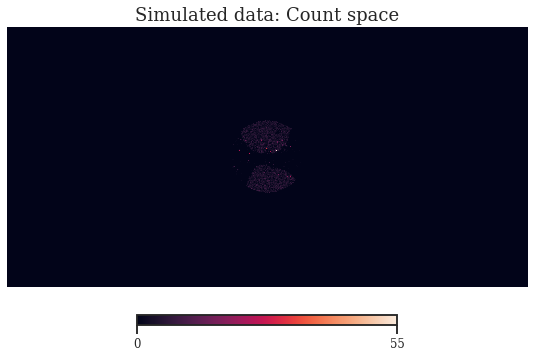

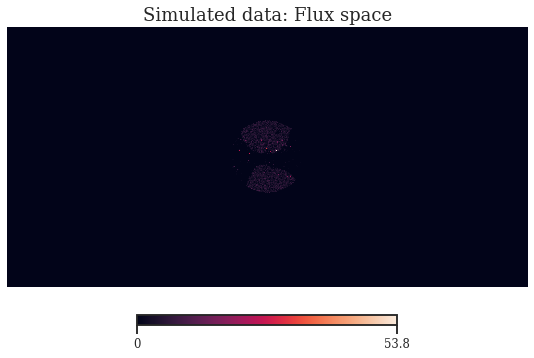

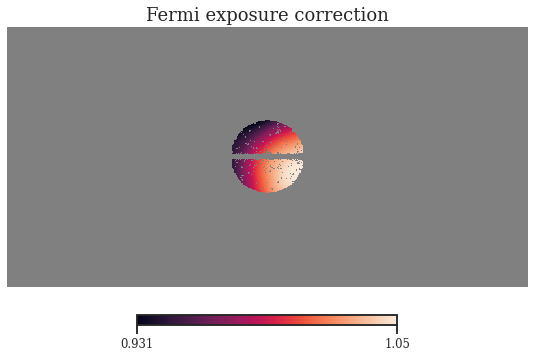

In [15]:
# NOTE: the maps are stored in NEST format
map_to_plot = 0
hp.cartview(gce.decompress(data[map_to_plot] * gce.template_dict["rescale_compressed"]), nest=True, title="Simulated data: Count space")
hp.cartview(gce.decompress(data[map_to_plot]), nest=True, title="Simulated data: Flux space")
hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"], fill_value=np.nan), nest=True,
            title="Fermi exposure correction")
plt.show()

Let's also plot the real *Fermi* map in our region of interest. Of course, it looks quite different from our simulated maps because we only included the *Fermi* bubbles, the GCE, and isotropic point sources in this example (so we are completely ignoring the diffuse Galactic foregrounds, which are responsible for the majority of photon counts).

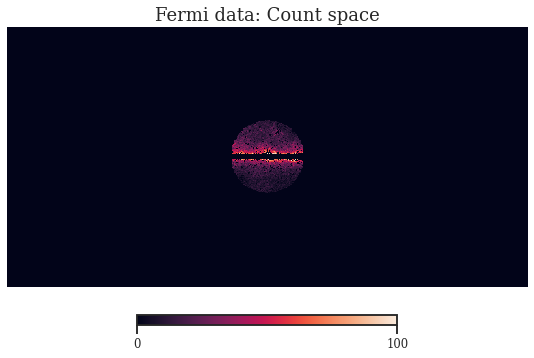

In [16]:
fermi_counts = gce.datasets["test"].get_fermi_counts()
hp.cartview(gce.decompress(fermi_counts * gce.generators["test"].settings_dict["rescale_compressed"]), nest=True,
            title="Fermi data: Count space", max=100)
# hp.cartview(gce.decompress(fermi_counts), nest=True, title="Fermi data: Flux space", max=100)
plt.show()

Now, it's time to **build** our neural network:

In [17]:
gce.build_nn()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

*NOTE*: Once the neural network has been trained, **loading** is as easy as ```gce.load_nn()```.

In [18]:
# gce.load_nn()

Let's **train** our neural network to predict 
1. the **flux fractions** of the different templates (using a negative maximum log-likelihood loss function), and 
2. the **SCD histograms** of the GCE and isotropic point source populations (using the *Earth Mover's pinball loss*, see [arXiv:2106.02051](https://arxiv.org/abs/2106.02051)).

In [19]:
gce.train_nn("flux_fractions")

Training flux fractions from scratch.
19 tensor(s) will be trained.

=== STARTING TRAINING ===


  0%|          | 0/500 [00:00<?, ?it/s]

Validation: End of epoch!


 50%|█████     | 250/500 [02:08<01:10,  3.55it/s, train_loss=-5.27]

Validation: End of epoch!


 59%|█████▊    | 293/500 [02:21<00:58,  3.56it/s, train_loss=-4.76]

Training: End of epoch!


100%|██████████| 500/500 [03:24<00:00,  2.45it/s, train_loss=-6.67]

=== TRAINING FINISHED ===



In [20]:
gce.train_nn("histograms")


Two checkpoint references resolved to different objects (<keras.optimizer_v2.adam.Adam object at 0x7f12e7ab0a10> and <keras.optimizer_v2.adam.Adam object at 0x7f12f95ef390>).
Restored flux fraction checkpoint from ../models/checkpoints/Example_comb_128/Training_1/ff/ckpt-500.
Training SCD histograms from scratch.
A new optimizer will be used for the training: initial learning rate is restored.
19 tensor(s) will be trained.

=== STARTING TRAINING ===


  0%|          | 0/500 [00:00<?, ?it/s]

Validation: End of epoch!
Validation: End of epoch!


 17%|█▋        | 85/500 [01:18<01:41,  4.09it/s, train_loss=0.0304]

Training: End of epoch!


 60%|██████    | 300/500 [02:13<00:48,  4.09it/s, train_loss=0.0302]

Validation: End of epoch!


 77%|███████▋  | 385/500 [02:35<00:27,  4.14it/s, train_loss=0.0332]

Training: End of epoch!


100%|██████████| 500/500 [03:05<00:00,  2.69it/s, train_loss=0.0275]

=== TRAINING FINISHED ===



Finally, let's **evaluate** the performance of our neural network on simulated test data.

In [21]:
n_samples = 20
test_samples = gce.datasets["test"].get_samples(n_samples)
test_data, test_ffs, test_hists = test_samples["data"], test_samples["label"][0], test_samples["label"][1]
tau = np.arange(5, 100, 5) * 0.01  # quantile levels for SCD histograms, from 5% to 95% in steps of 5%
pred = gce.predict(test_data, tau=tau, multiple_taus=True)  # get the NN predictions

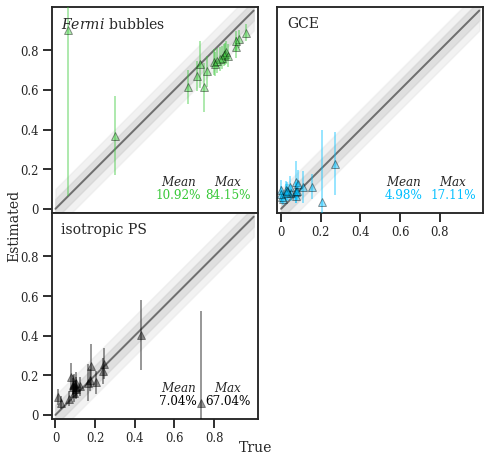

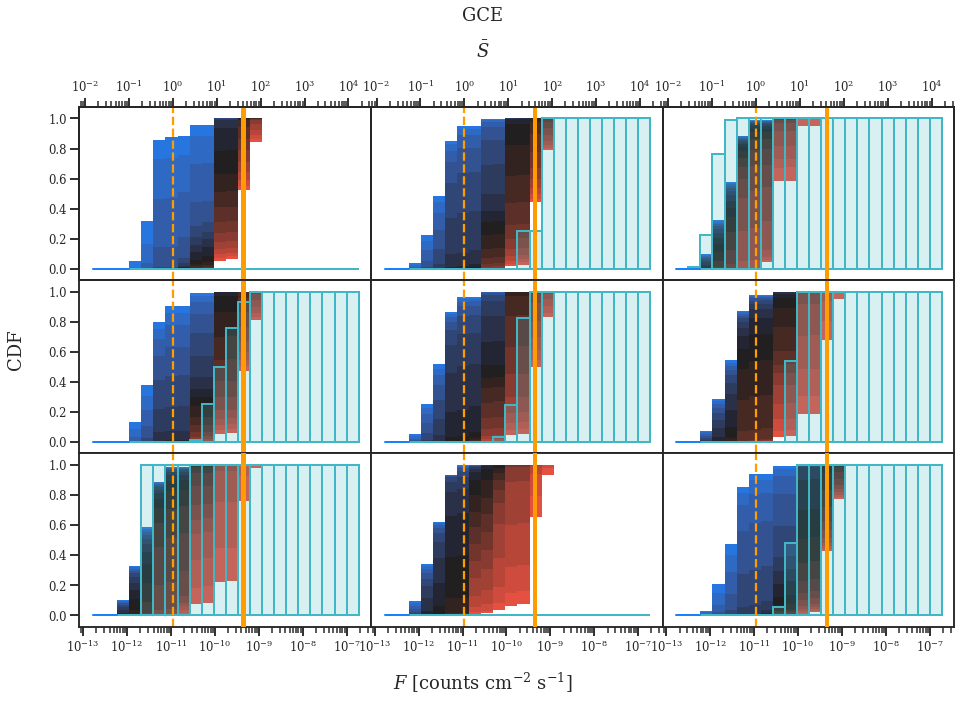

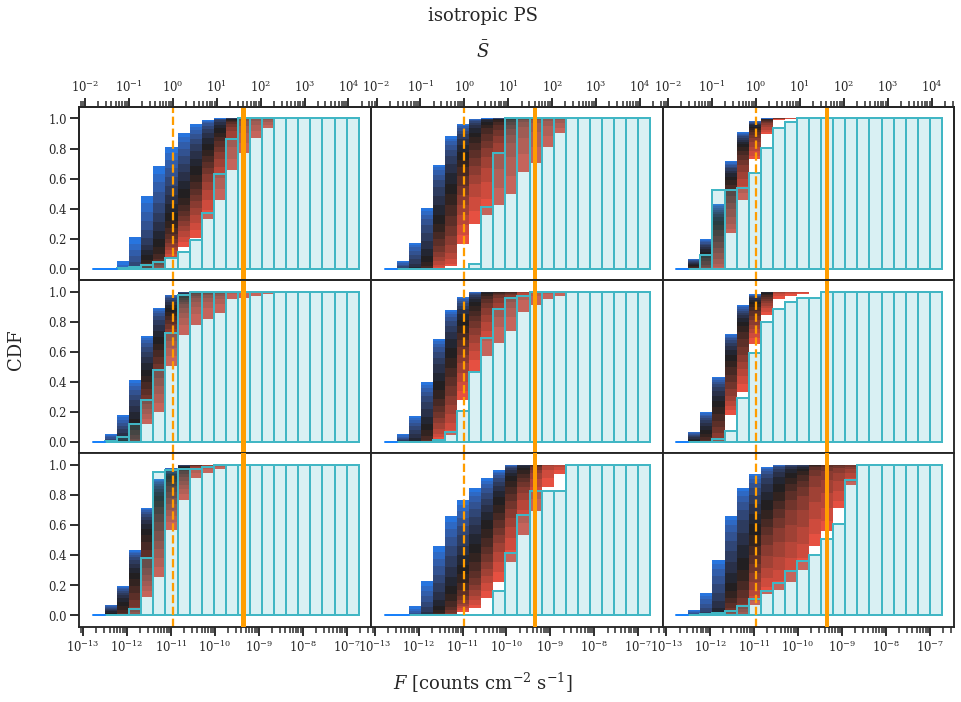

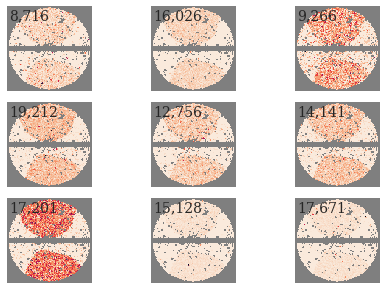

In [22]:
# Make some plots (will be saved in the models folder)
gce.plot_nn_architecture()
gce.plot_flux_fractions(test_ffs, pred)
gce.plot_histograms(test_hists, pred, plot_inds=np.arange(9))
gce.plot_maps(test_data, decompress=True, plot_inds=np.arange(9))
plt.show()

Clearly, the training dataset is too small and the training was too short to obtain accurate and precise predictions. Still, the neural networks have already learned *something*, and the predictions are roughly in the right ballpark.